# What causes variability in our influent flow?

## Setup - Get the tools
For an all-in-one Python environment, download and install [Anaconda](https://www.anaconda.com/products/individual).

### Install required packages
Packages are additional free tools that you can leverage from Python.

Open "Anaconda Prompt" from the Start Menu and run these three commands:

```
conda install pandas
conda install plotly
conda install -c conda-forge fbprophet
```


### Open this notebook
1. In the Start Menu, find "Jupyter Notebook"
2. Download the file you're reading right now and open it in Jupyter Notebook.

## Step 1 - Get the Data

Arrange the data into a "long" format, like this:

| date       | inf_flow_mgd   | rainfall_in
| ---------- | -------------- | -------------------
| 2020-01-01 | 10.0           | 0
| 2020-01-02 | 10.3           | 0
| 2020-01-03 | 11.0           | 0.4
| 2020-01-04 | 10.7           | 0
| ...        | ...            | ...

Save it as a CSV.

`inf_and_rain.csv:`
```
date,inf_flow_mgd,rainfall_in
2020-01-01,10.0,0
2020-01-02,10.3,0
2020-01-03,11.0,0.4
2020-01-04,10.7,0
```

Many utilities have the ability to export data to a CSV or Excel file in this format.

## Step 2 - Read in the data

In [1]:
# We'll use pandas to import the data.
# Pandas is sort of like an advanced Excel for Python.
import pandas as pd

df = pd.read_csv("inf_and_rain.csv")

# Preview our table
df.head()

,date,inf_flow_mgd,rainfall_in
0,2010-03-01,6.745975,0.00
1,2010-03-02,6.669800,0.30
2,2010-03-03,7.350100,0.71
3,2010-03-04,7.306775,0.01
4,2010-03-05,6.615025,0.00


In [2]:
df.sample(20)

,date,inf_flow_mgd,rainfall_in
125,2010-07-04,3.408075,0.00
2300,2016-06-17,2.680000,0.00
3029,2018-06-16,2.830000,0.00
1498,2014-04-07,3.187575,0.00
2117,2015-12-17,NaN,0.00
707,2012-02-06,4.229000,0.00
1194,2013-06-07,3.255000,0.00
3551,2019-11-20,3.100000,0.02
572,2011-09-24,3.708000,0.00
455,2011-05-30,4.430000,0.00


In [3]:
# Let's graph the data.


# Plotly is a handy tool for making interactive graphs
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df["date"], y=df["inf_flow_mgd"], name="Influent Flow (MGD)"))
fig.add_trace(go.Scatter(x=df["date"], y=df["rainfall_in"], name="Rainfall (In)"))
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

# Looks pretty noisy...but we see some cycles throughout the year.

# Building a forecast

We're going to build a Time Series Forecasting model to predict next year's flows and learn about our system.

Facebook has built a free package for doing this called [Prophet](https://facebook.github.io/prophet/)

Most forecasting is just about finding cycles: Over years, seasons, weeks, days.

In [4]:
# Prophet expects our table to have columns "ds" and "y" (for whatever reason)

df = df.rename(columns={"date": "ds", "inf_flow_mgd": "y"})
df.head()

,ds,y,rainfall_in
0,2010-03-01,6.745975,0.00
1,2010-03-02,6.669800,0.30
2,2010-03-03,7.350100,0.71
3,2010-03-04,7.306775,0.01
4,2010-03-05,6.615025,0.00


In [5]:
# Import the library
from fbprophet import Prophet

m = Prophet()

# Make a predictive model
m.fit(df)

# Create an empty dataframe with "slots" for each day of the next year
future = m.make_future_dataframe(periods=365)

# Projecting into the future!
future.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
4279,2021-11-17
4280,2021-11-18
4281,2021-11-19
4282,2021-11-20
4283,2021-11-21


In [6]:
# Now fill in that dataframe with predictions
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4279,2021-11-17,2.783136,1.856204,3.771094
4280,2021-11-18,2.774629,1.861621,3.738938
4281,2021-11-19,2.794708,1.895817,3.754853
4282,2021-11-20,2.755432,1.789968,3.678255
4283,2021-11-21,2.754012,1.808461,3.704109


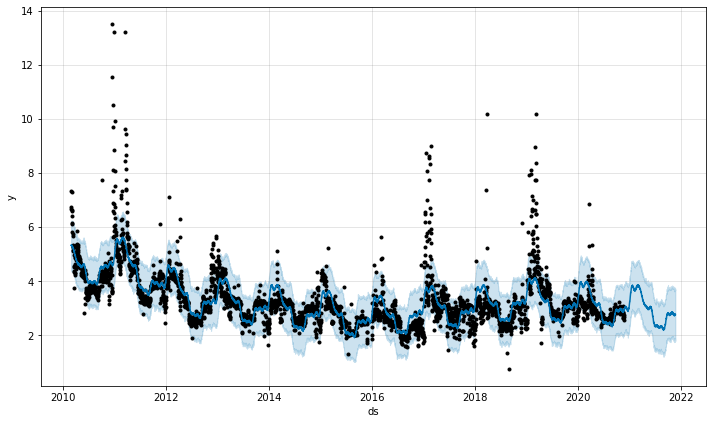

In [7]:
# Simple plot:
fig1 = m.plot(forecast)

In [8]:
# Fancy plot
import plotly.offline as pyo
from fbprophet.plot import plot_plotly

fig1 = plot_plotly(m, forecast)  # This returns a plotly Figure
pyo.iplot(fig1)

In the above data, the black dots are daily readings of influent flow in MGD. The blue line is the prediction for the next year that was made in January.
The scattering seen in Jan-Mar is the effect of rainfall, showing a high I&I. In a separate analysis, I pulled in rainfall data from a local weather station and found some interesting correlations. But this post is about learning from one parameter, so you’ll have to wait for a later blog post to learn about the rainfall analysis.

### So how was that prediction made?

The Prophet library breaks the data down into long-term trends and cyclical patterns, then simply sums them together.

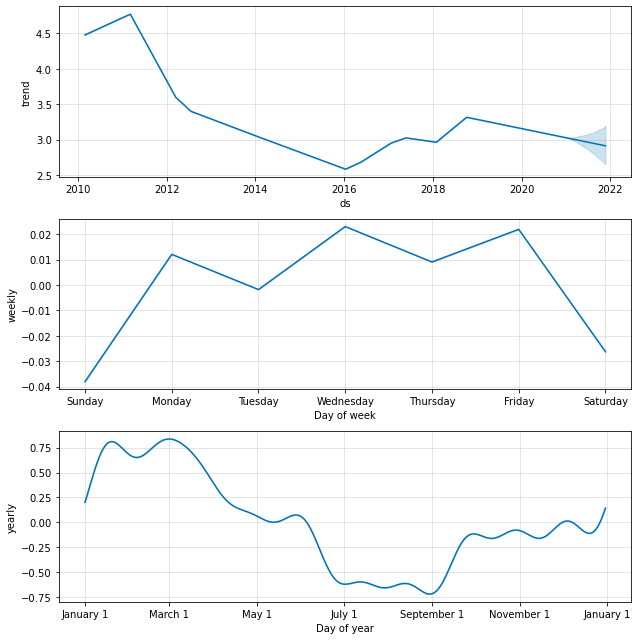

In [9]:
# View seasonality components
fig2 = m.plot_components(forecast)


### Overall Trend
The overall trend is likely to follow what many utilities have seen in California. Back in 2010, flows were higher, reflective of more usage overall. Flows decreased all the way to 2017, the peak of the drought. Not only were rain events less frequent (reducing average flow due to I&I), but water conservation measures in homes, such as shorter showers, were at their peaks.
 
### Annual Patterns
On an annually repeating basis, we tend to see higher flows in January through March – the peak rain season for this area. July through September, we see an unusual drop. That is because this is a college town, which sees a drop in population of about 15,000 every summer.
 
### Weekly Patterns
Then, on a weekly basis, we see roughly 50,000 gallons a day higher on Monday through Friday than on Saturday and Sunday. I didn’t know what to make of this, so I asked the operators. They said it’s because this town is a hub – at least, pre-COVID – and so thousands of people come into the city to “do their business” Monday through Friday, then stay home on the weekends.


From a simple graph, we’re able to tell quite interesting stories about the population of this wastewater plant’s city.